# **Project 3**

Phân tích hành vi tiêu dùng và dự báo khách hành trung thành bằng mô hình Random Forest Regressor

## Import thư viện

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

## Đọc dữ liệu và kiểm tra thông tin dữ liệu

In [2]:
ecom_data = pd.read_csv('Data/E-commerce Customer Behavior.csv')
print("Dữ liệu ban đầu (5 dòng đầu):")
print(ecom_data.head())
print("\nThông tin dữ liệu:")
ecom_data.info()

Dữ liệu ban đầu (5 dòng đầu):
   Customer ID  Gender  Age           City Membership Type  Total Spend  \
0          101  Female   29       New York            Gold      1120.20   
1          102    Male   34    Los Angeles          Silver       780.50   
2          103  Female   43        Chicago          Bronze       510.75   
3          104    Male   30  San Francisco            Gold      1480.30   
4          105    Male   27          Miami          Silver       720.40   

   Items Purchased  Average Rating  Discount Applied  \
0               14             4.6              True   
1               11             4.1             False   
2                9             3.4              True   
3               19             4.7             False   
4               13             4.0              True   

   Days Since Last Purchase Satisfaction Level  
0                        25          Satisfied  
1                        18            Neutral  
2                        42        

In [3]:
ecom_data.isnull().sum()

Customer ID                 0
Gender                      0
Age                         0
City                        0
Membership Type             0
Total Spend                 0
Items Purchased             0
Average Rating              0
Discount Applied            0
Days Since Last Purchase    0
Satisfaction Level          2
dtype: int64

Kiểm tra giá trị null thì ta thấy có 2 giá trị ở trường Satisfaction Level 

In [4]:
print("\nSummary Statistics:")
summary_stats = ecom_data.describe()

# Chỉ lấy các cột có kiểu dữ liệu số
numeric_cols = ecom_data.select_dtypes(include=['number'])
summary_stats.loc['median'] = numeric_cols.median() 
summary_stats.loc['skewness'] = numeric_cols.skew() 
summary_stats  


Summary Statistics:


,Customer ID,Age,Total Spend,Items Purchased,Average Rating,Days Since Last Purchase
count,350.000000,350.000000,350.000000,350.000000,350.000000,350.000000
mean,275.500000,33.597143,845.381714,12.600000,4.019143,26.588571
std,101.180532,4.870882,362.058695,4.155984,0.580539,13.440813
min,101.000000,26.000000,410.800000,7.000000,3.000000,9.000000
25%,188.250000,30.000000,502.000000,9.000000,3.500000,15.000000
50%,275.500000,32.500000,775.200000,12.000000,4.100000,23.000000
75%,362.750000,37.000000,1160.600000,15.000000,4.500000,38.000000
max,450.000000,43.000000,1520.100000,21.000000,4.900000,63.000000
median,275.500000,32.500000,775.200000,12.000000,4.100000,23.000000
skewness,0.000000,0.468340,0.562567,0.649160,-0.126820,0.677545


Thống kê tóm tắt bộ dữ liệu: 
- Các đặc trưng hành vi và tương
 tác được lượng hóa thông qua 6 biến định lượng chính: Age, Total Spend, Item
 Purchased, Average Rating, Days Since Last Purchase và Customer ID.

## Trực quan hóa dữ liệu

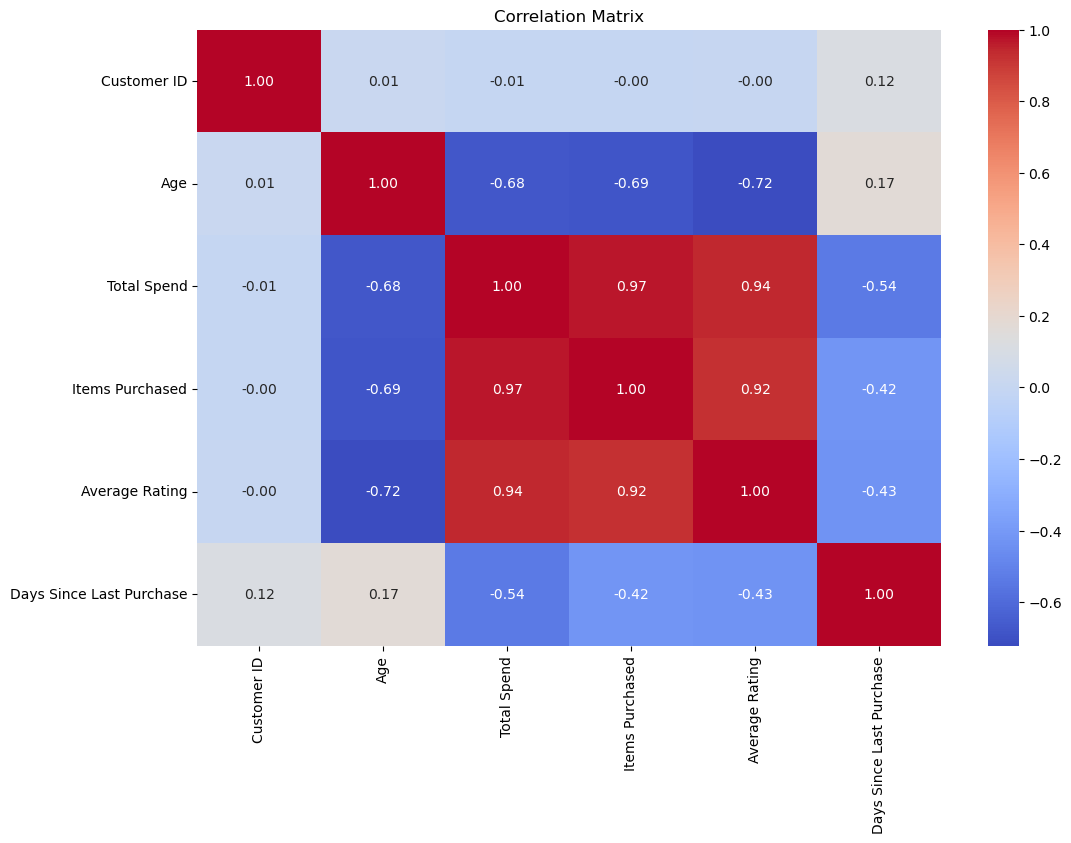

In [5]:
# Correlation Matrix
numeric_columns = ecom_data.select_dtypes(include='number')
correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## Tiền xử lỹ dữ liệu

In [6]:
# 1
ecom_data = ecom_data.drop('Customer ID', axis=1)

# 2
ecom_data = pd.get_dummies(ecom_data, columns=['Gender'], prefix='Gender', drop_first=True) 

# 3
region_map = {
    'New York': 'Northeast',
    'Chicago': 'Midwest',
    'Miami': 'South',
    'Houston': 'South',
    'Los Angeles': 'West',
    'San Francisco': 'West'
}
ecom_data['Region'] = ecom_data['City'].map(region_map)

# 4
ecom_data = pd.get_dummies(ecom_data, columns=['Region'], prefix='Region', drop_first=True)
ecom_data = ecom_data.drop('City', axis=1) # Bỏ cột City gốc

# 5
ecom_data = pd.get_dummies(ecom_data, columns=['Membership Type'], prefix='Membership', drop_first=True)

# 6
ecom_data['Discount Applied'] = ecom_data['Discount Applied'].astype(int)

# 7
ecom_data['Satisfaction Level'].fillna(ecom_data['Satisfaction Level'].mode()[0], inplace=True)
satisfaction_map = {
    'Unsatisfied': 0,
    'Neutral': 1,
    'Satisfied': 2
}
ecom_data['Satisfaction Level'] = ecom_data['Satisfaction Level'].map(satisfaction_map)

# 8
new_cols = ['Gender_Male', 'Region_Northeast','Region_South','Region_West','Membership_Gold','Membership_Silver']
ecom_data[new_cols] = ecom_data[new_cols].astype(int)

1. Bỏ cột 'Customer ID' vì không phải là đặc trưng
2. Xử lý cột 'Gender': One-Hot Encoding
3. Xử lý cột 'City': Ánh xạ sang 'Region' và One-Hot Encoding
4. Xử lý NaN nếu có thành phố không khớp trong map
5. Xử lý cột 'Membership Type': One-Hot Encoding
6. Xử lý cột 'Discount Applied': Chuyển đổi True/False sang 1/0
7. Xử lý cột 'Satisfaction Level': Xử lý 2 giá trị missing rồi chuyển đổi sang số
8. Cuối cùng định dạng lại những trường sang int

In [7]:
ecom_data

,Age,Total Spend,Items Purchased,Average Rating,Discount Applied,Days Since Last Purchase,Satisfaction Level,Gender_Male,Region_Northeast,Region_South,Region_West,Membership_Gold,Membership_Silver
0,29,1120.20,14,4.6,1,25,2,0,1,0,0,1,0
1,34,780.50,11,4.1,0,18,1,1,0,0,1,0,1
2,43,510.75,9,3.4,1,42,0,0,0,0,0,0,0
3,30,1480.30,19,4.7,0,12,2,1,0,0,1,1,0
4,27,720.40,13,4.0,1,55,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
345,32,660.30,10,3.8,1,42,0,1,0,1,0,0,1
346,36,470.50,8,3.0,0,27,1,0,0,1,0,0,0
347,30,1190.80,16,4.5,1,28,2,0,1,0,0,1,0
348,34,780.20,11,4.2,0,21,1,1,0,0,1,0,1


Kiểm tra lại bộ dữ liệu sau khi tiền xử lý

In [8]:
# Ánh xạ Membership Type thành điểm số: Bronze = 0, Silver = 0.5, Gold = 1
ecom_data['MembershipScore'] = 0  # mặc định
if 'Membership_Silver' in ecom_data.columns:
    ecom_data['MembershipScore'] += 0.5 * ecom_data['Membership_Silver']
if 'Membership_Gold' in ecom_data.columns:
    ecom_data['MembershipScore'] += 1.0 * ecom_data['Membership_Gold']

# Khởi tạo scaler để chuẩn hóa
scaler = MinMaxScaler()

# Tính điểm hành vi đã chuẩn hóa
ecom_data['RecencyScore'] = 1 - scaler.fit_transform(ecom_data[['Days Since Last Purchase']])  # càng gần càng cao
ecom_data['FrequencyScore'] = scaler.fit_transform(ecom_data[['Items Purchased']])
ecom_data['MonetaryScore'] = scaler.fit_transform(ecom_data[['Total Spend']])
ecom_data['RatingScore'] = scaler.fit_transform(ecom_data[['Average Rating']])

# Tính điểm trung thành Loyalty Score theo công thức tổng hợp có trọng số
ecom_data['LoyaltyScore'] = (
    0.25 * ecom_data['RecencyScore'] +
    0.25 * ecom_data['FrequencyScore'] +
    0.25 * ecom_data['MonetaryScore'] +
    0.15 * ecom_data['RatingScore'] +
    0.10 * ecom_data['MembershipScore']
)

# Xem 5 Loyalty Score đầu tiên
ecom_data[['LoyaltyScore']].head()

,LoyaltyScore
0,0.687117
1,0.499922
2,0.187041
3,0.925638
4,0.342901


Tạo biến mục tiêu LoyaltyScore chính là biến dự báo để sử dụng trong mô hình

LoyaltyScore = 0.25.RecencyScore + 0.25.FrequencyScore + 0.25.MonetaryScore + 0.15. RatingScore + 0.10. MembershipScore. 

(5 biến này đều là biến có tác động lớn đến chỉ số hài lòng)

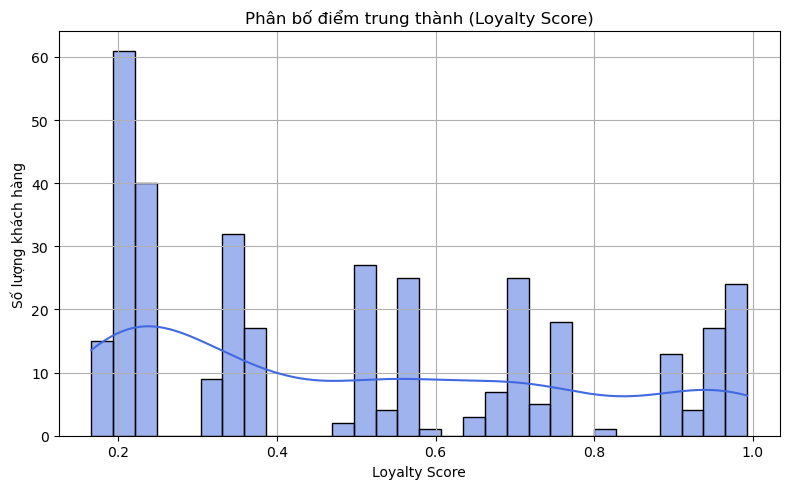

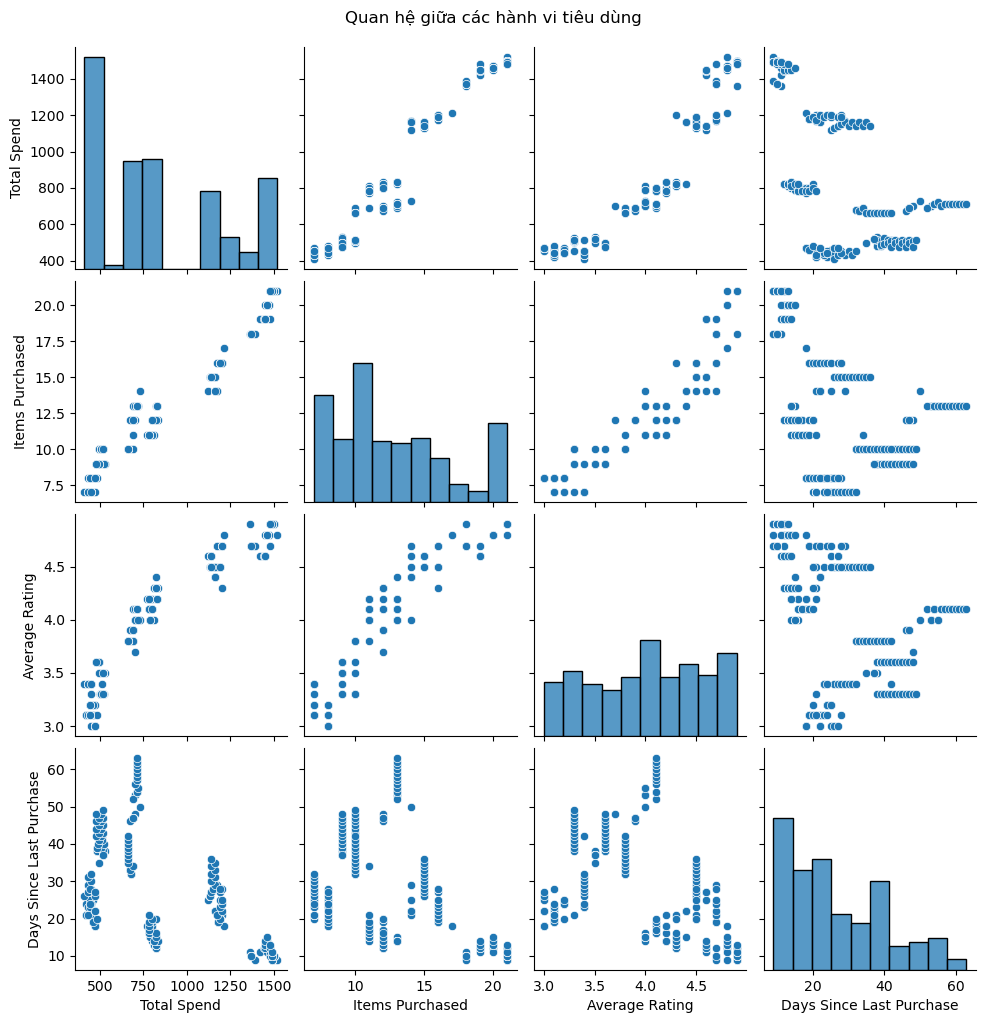

In [9]:
plt.figure(figsize=(8, 5))
sns.histplot(ecom_data['LoyaltyScore'], kde=True, bins=30, color="royalblue")
plt.title("Phân bố điểm trung thành (Loyalty Score)")
plt.xlabel("Loyalty Score")
plt.ylabel("Số lượng khách hàng")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Biểu đồ 2: Pairplot các đặc trưng hành vi chính ---
selected_cols = ['Total Spend', 'Items Purchased', 'Average Rating', 'Days Since Last Purchase']
sns.pairplot(ecom_data[selected_cols], diag_kind='hist')
plt.suptitle("Quan hệ giữa các hành vi tiêu dùng", y=1.02)
plt.show()


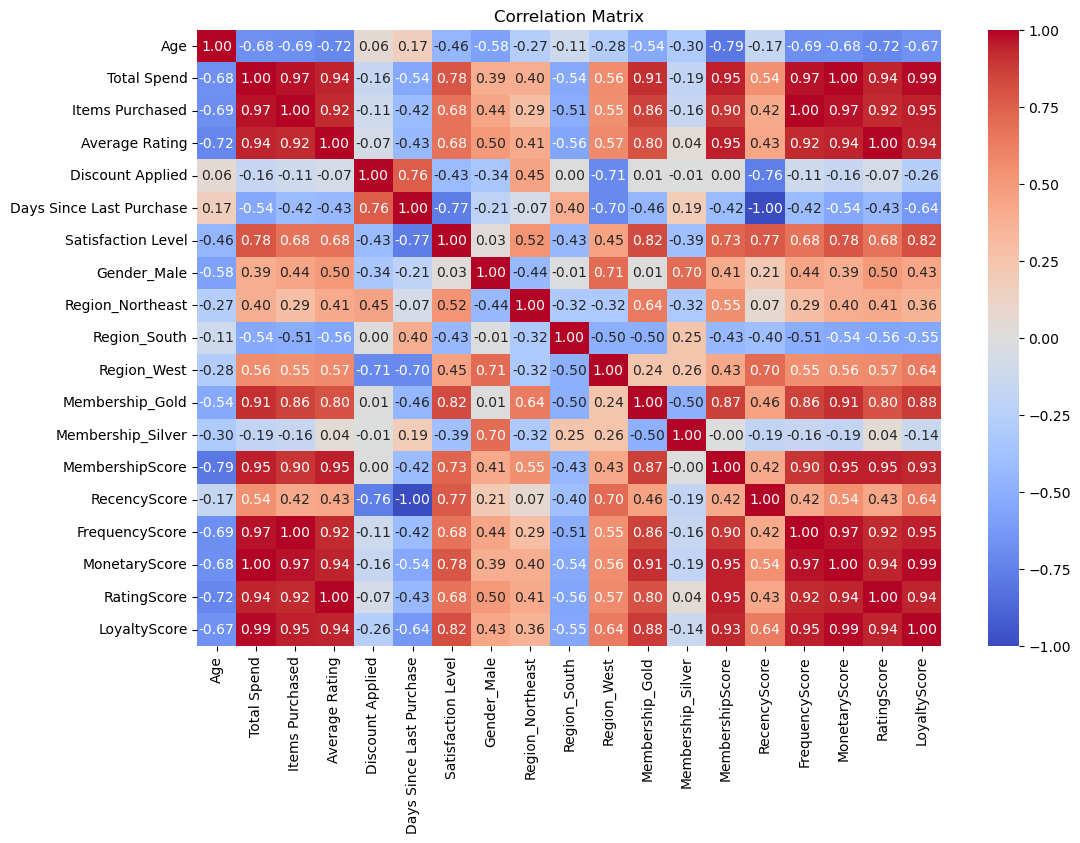

In [10]:
# Correlation Matrix
numeric_columns = ecom_data.select_dtypes(include='number')
correlation_matrix = numeric_columns.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

## Chia tập và Huấn luyện mô hình

In [11]:
# --- Xác định Features (X) và Target (y) ---

# Biến mục tiêu là 'LoyaltyScore'
y = ecom_data['LoyaltyScore']

# Các biến đặc trưng (loại bỏ biến mục tiêu và Customer ID nếu chưa bỏ)
X = ecom_data.drop('LoyaltyScore', axis=1)

# Đảm bảo tất cả các cột trong X đều là số
print("\nKiểm tra kiểu dữ liệu của các cột trong X:")
print(X.dtypes)


Kiểm tra kiểu dữ liệu của các cột trong X:
Age                           int64
Total Spend                 float64
Items Purchased               int64
Average Rating              float64
Discount Applied              int32
Days Since Last Purchase      int64
Satisfaction Level            int64
Gender_Male                   int32
Region_Northeast              int32
Region_South                  int32
Region_West                   int32
Membership_Gold               int32
Membership_Silver             int32
MembershipScore             float64
RecencyScore                float64
FrequencyScore              float64
MonetaryScore               float64
RatingScore                 float64
dtype: object


In [12]:
y = ecom_data['LoyaltyScore']
X = ecom_data.drop('LoyaltyScore', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
# --- Chia tập dữ liệu Training và Testing ---


print(f"\nKích thước tập huấn luyện X_train: {X_train.shape}")
print(f"Kích thước tập kiểm tra X_test: {X_test.shape}")
print(f"Kích thước tập huấn luyện y_train: {y_train.shape}")
print(f"Kích thước tập kiểm tra y_test: {y_test.shape}")



Kích thước tập huấn luyện X_train: (280, 18)
Kích thước tập kiểm tra X_test: (70, 18)
Kích thước tập huấn luyện y_train: (280,)
Kích thước tập kiểm tra y_test: (70,)


In [14]:
# --- Xây dựng và huấn luyện mô hình Random Forest Regressor ---
model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1) # n_jobs=-1 để sử dụng tất cả các core CPU

print("\nĐang huấn luyện mô hình Random Forest Regressor...")
model.fit(X_train, y_train)
print("Huấn luyện mô hình hoàn tất.")




Đang huấn luyện mô hình Random Forest Regressor...
Huấn luyện mô hình hoàn tất.


In [15]:
# --- Dự đoán trên tập kiểm tra ---
y_pred = model.predict(X_test)

### Đánh giá hiệu suất mô hình chính và so sánh với các mô hình khác

**Random Forest Regrssor**

In [16]:
# --- Đánh giá hiệu suất mô hình ---
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\nKết quả đánh giá mô hình Random Forest Regressor:")
print(f"Mean Squared Error (MSE): {mse:.6f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.6f}")
print(f"Mean Absolute Error (MAE): {mae:.6f}")
print(f"R-squared (R2): {r2:.6f}")



Kết quả đánh giá mô hình Random Forest Regressor:
Mean Squared Error (MSE): 0.000015
Root Mean Squared Error (RMSE): 0.003906
Mean Absolute Error (MAE): 0.001940
R-squared (R2): 0.999793


**XGBoostRegressor**

In [17]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(random_state=42, objective='reg:squarederror')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
rmse_xgb = mean_squared_error(y_test, y_pred_xgb, squared=False)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f"XGBoost Regressor:\nMAE: {mae_xgb:.6f}, RMSE: {rmse_xgb:.6f}, R2: {r2_xgb:.6f}")

XGBoost Regressor:
MAE: 0.002448, RMSE: 0.006626, R2: 0.999403


**DecisionTreeRegressor**

In [18]:
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)

mae_dt = mean_absolute_error(y_test, y_pred_dt)
rmse_dt = mean_squared_error(y_test, y_pred_dt, squared=False)
r2_dt = r2_score(y_test, y_pred_dt)

print(f"Decision Tree Regressor:\nMAE: {mae_dt:.6f}, RMSE: {rmse_dt:.6f}, R2: {r2_dt:.6f}")

Decision Tree Regressor:
MAE: 0.003103, RMSE: 0.011957, R2: 0.998057


**KNeighborsRegressor**

In [19]:
from sklearn.neighbors import KNeighborsRegressor

knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

mae_knn = mean_absolute_error(y_test, y_pred_knn)
rmse_knn = mean_squared_error(y_test, y_pred_knn, squared=False)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"KNN Regressor:\nMAE: {mae_knn:.6f}, RMSE: {rmse_knn:.6f}, R2: {r2_knn:.6f}")

KNN Regressor:
MAE: 0.006079, RMSE: 0.012629, R2: 0.997833


**So sánh các mô hình**

In [20]:
results = pd.DataFrame({
    'Model': ['Random Forest Regressor', 'XGBoost', 'Decision Tree', 'KNN'],
    'MAE': [mse, mae_xgb, mae_dt, mae_knn],
    'RMSE': [rmse, rmse_xgb, rmse_dt, rmse_knn],
    'R2 Score': [r2, r2_xgb, r2_dt, r2_knn]
})
results['MAE'] = results['MAE'].round(6)
results['RMSE'] = results['RMSE'].round(6)
results['R2 Score'] = results['R2 Score'].round(6)
print(results.sort_values(by='R2 Score', ascending=False))

                     Model       MAE      RMSE  R2 Score
0  Random Forest Regressor  0.000015  0.003906  0.999793
1                  XGBoost  0.002448  0.006626  0.999403
2            Decision Tree  0.003103  0.011957  0.998057
3                      KNN  0.006079  0.012629  0.997833


Ta thấy mô hình Random Forest Regressor đạt hiệu quả cao nhất cũng như sai số thấp nhất.

Điều này cho thấy mô hình rất phù hợp với tập dữ liệu  => Dự báo càng chính xác

## Kiểm tra kết quả dự báo

### Kiểm tra các đặc trưng quan trọng nhất trong mô hình


Top 10 đặc trưng quan trọng nhất:
              Feature  Importance
16      MonetaryScore    0.426969
1         Total Spend    0.384284
15     FrequencyScore    0.047637
2     Items Purchased    0.025435
3      Average Rating    0.023547
13    MembershipScore    0.020676
17        RatingScore    0.016404
11    Membership_Gold    0.010043
12  Membership_Silver    0.009936
10        Region_West    0.008623


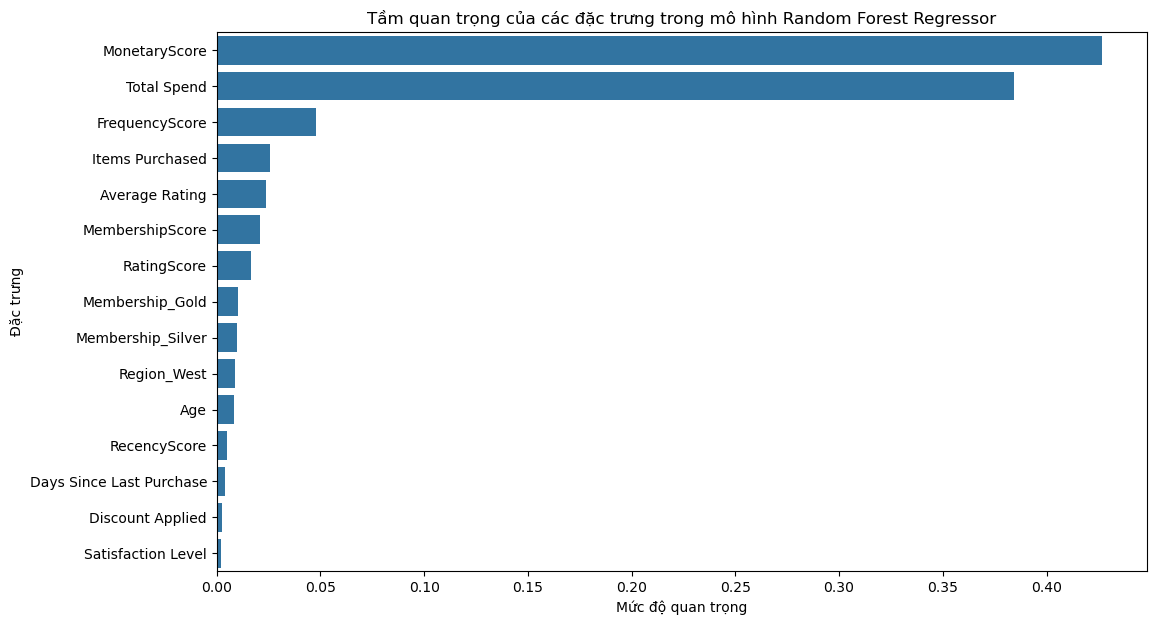

In [21]:
# --- Phân tích tầm quan trọng của các đặc trưng (Feature Importance) ---
feature_importances = model.feature_importances_
features_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
features_df = features_df.sort_values(by='Importance', ascending=False)

print("\nTop 10 đặc trưng quan trọng nhất:")
print(features_df.head(10))

# Trực quan hóa tầm quan trọng của đặc trưng
plt.figure(figsize=(12, 7))
sns.barplot(x='Importance', y='Feature', data=features_df.head(15))
plt.title('Tầm quan trọng của các đặc trưng trong mô hình Random Forest Regressor')
plt.xlabel('Mức độ quan trọng')
plt.ylabel('Đặc trưng')
plt.show()

Ta thấy có 2 đặc trưng quan trọng chiếm phần lớn đó chính là:
- MonetaryScore với 0.426969 chiếm gần 43% mức độ ảnh hưởng. Đây là kết quả hợp lý bởi khách hàng có xu hướng trung thành cao hơn khi họ chi tiêu nhiều hơn.
- Đặc trưng Total Spend cũng có tầm quan trọng rất lớn, xấp xỉ gần 38%, góp phần khẳng định rằng tổng chi tiêu thực tế là chỉ số chủ đạo không kém trong việc xác định lòng trung thành.
  
Các đặc trưng tiếp theo như FrequencyScore và Items Purchased có mức độ quan trọng thấp hơn nhưng vẫn đáng kể, lần lượt khoảng dưới 6% và 4%. Điều này cho thấy tần suất mua hàng và số lượng sản phẩm đã mua cũng góp phần tích cực vào dự đoán.

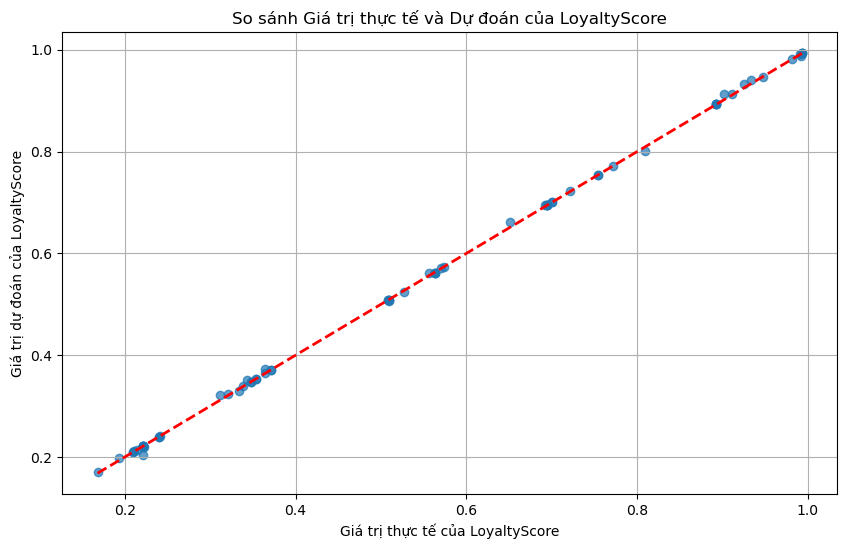

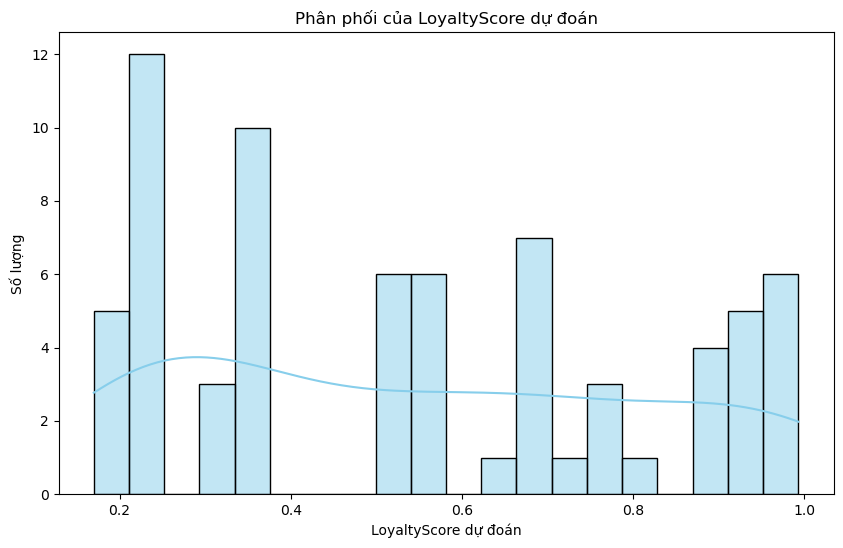

In [22]:
# --- Trực quan hóa kết quả dự đoán ---
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # Đường y=x
plt.xlabel('Giá trị thực tế của LoyaltyScore')
plt.ylabel('Giá trị dự đoán của LoyaltyScore')
plt.title('So sánh Giá trị thực tế và Dự đoán của LoyaltyScore')
plt.grid(True)
plt.show()

# Phân tích phân phối của LoyaltyScore dự đoán
plt.figure(figsize=(10, 6))
sns.histplot(y_pred, kde=True, bins=20, color='skyblue')
plt.title('Phân phối của LoyaltyScore dự đoán')
plt.xlabel('LoyaltyScore dự đoán')
plt.ylabel('Số lượng')
plt.show()


**Biều đồ 1**: *So sánh Giá trị thực tế và Dự đoán của LoyaltyScore*
- Với đường màu đỏ x = y là đường thực tế và các điểm chấm là dự bao. Ta thấy các chấm rất sát với giá trị thực tế, không có điểm nào nằm cách xa giá trị thực tế. Điều này cho thấy không có giá trị outliers lớn, độ lệch giữa giá trị dự báo và thực tế rất nhỏ.
- Mô hình có khả năng dự đoán chính xác mức độ trung thành của khách hàng, từ khách hàng có LoyaltyScore thấp (ít trung thành) đến cao (rất trung thành). Dự đoán chính xác giúp doanh nghiệp tự tin phân nhóm và đưa ra chiến lược phù hợp, ví dụ như tập trung ưu tiên chăm sóc nhóm khách hàng trung thành cao hoặc đưa ra chương trình thu hút nhóm trung thành thấp. Việc mô hình không bị overfitting (không dự đoán tốt trên tập huấn luyện nhưng kém trên tập kiểm tra) giúp tăng độ tin cậy khi áp dụng vào dữ liệu thực tế.

**Biểu đồ 2**: *Phân phối của LoyaltyScore dự đoán*
- Biều đồ Histogram cho thấy nhiều đỉnh với số lượng khách hàng tập trung quanh các giá trị LoyaltyScore khác nhau (~0.2, 0.35, 0.55, 0.7 0.9). Ta thấy ~0.2 và ~0.35 có số lượng khách hàng nhiều nhất, có thể phản ánh rằng trên dữ liệu thực tế, nhiều khách hàng có mức trung thành thấp hoặc trung bình, phù hợp với thị trường thực tế.
- Đường KDE mượt mà: Đường mật độ xác suất không có bước nhảy hay biến động đột ngột, chứng tỏ dữ liệu dự đoán phân bố tự nhiên, không bị méo hay bất thường.


Kết quả dự đoán LoyaltyScore và phân loại trung thành:
Khách hàng 157: LoyaltyScore dự đoán = 0.56 -> Không trung thành
Khách hàng 341: LoyaltyScore dự đoán = 0.66 -> Không trung thành
Khách hàng 315: LoyaltyScore dự đoán = 0.32 -> Không trung thành
Khách hàng 234: LoyaltyScore dự đoán = 0.57 -> Không trung thành
Khách hàng 155: LoyaltyScore dự đoán = 0.22 -> Không trung thành
Khách hàng 274: LoyaltyScore dự đoán = 0.22 -> Không trung thành
Khách hàng 304: LoyaltyScore dự đoán = 0.20 -> Không trung thành
Khách hàng 227: LoyaltyScore dự đoán = 0.69 -> Không trung thành
Khách hàng 278: LoyaltyScore dự đoán = 0.91 -> Trung thành
Khách hàng 185: LoyaltyScore dự đoán = 0.22 -> Không trung thành

Số lượng khách hàng trung thành dự đoán: 20
Số lượng khách hàng không trung thành dự đoán: 50
Tỷ lệ khách hàng trung thành dự đoán: 28.57%


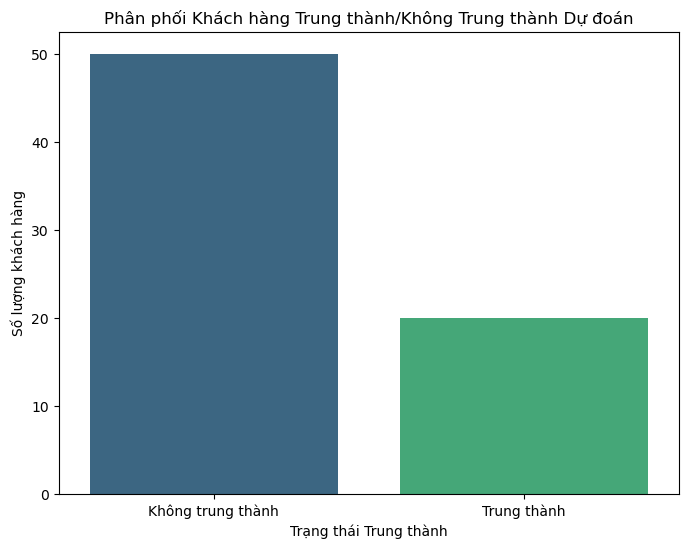

In [23]:
loyalty_threshold = 0.7

# Tạo danh sách các dự đoán phân loại
predicted_loyalty_category = []
for score in y_pred:
    if score >= loyalty_threshold:
        predicted_loyalty_category.append("Trung thành")
    else:
        predicted_loyalty_category.append("Không trung thành")

print("\nKết quả dự đoán LoyaltyScore và phân loại trung thành:")
for i in range(min(10, len(y_pred))): # In ra 10 kết quả đầu tiên
    category = "Trung thành" if y_pred[i] >= loyalty_threshold else "Không trung thành"
    print(f"Khách hàng {X_test.index[i]}: LoyaltyScore dự đoán = {y_pred[i]:.2f} -> {category}")

# Phân tích phân phối của các khách hàng trung thành dự đoán
loyal_customers_count = sum(1 for score in y_pred if score >= loyalty_threshold)
non_loyal_customers_count = len(y_pred) - loyal_customers_count

print(f"\nSố lượng khách hàng trung thành dự đoán: {loyal_customers_count}")
print(f"Số lượng khách hàng không trung thành dự đoán: {non_loyal_customers_count}")
print(f"Tỷ lệ khách hàng trung thành dự đoán: {loyal_customers_count / len(y_pred) * 100:.2f}%")

# Trực quan hóa kết quả phân loại
plt.figure(figsize=(8, 6))
sns.countplot(x=predicted_loyalty_category, palette='viridis')
plt.title('Phân phối Khách hàng Trung thành/Không Trung thành Dự đoán')
plt.xlabel('Trạng thái Trung thành')
plt.ylabel('Số lượng khách hàng')
plt.show()

Tạo ngưỡng điểm LoyaltyScore trung thành với điểm LoyaltyScore dự báo lớn hơn 0.7 là trung thành và ngược lại.

**Biểu đồ**: Phân phối Khách hàng Trung thành/Không Trung thành Dự đoán

- Số lượng khách hàng trung thành dự đoán: 20
- Số lượng khách hàng không trung thành dự đoán: 5
- Tỷ lệ khách hàng trung thành dự đoán: 28.57%